In [25]:
# Enable TensorFlow 2
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random

print(tf.__version__)

2.0.0


In [0]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [28]:
print('Normalize the input image so that each pixel value is between 0 to 1')
train_images = train_images / 255.0
test_images = test_images / 255.0
print('Pixels are normalized')

Normalize the input image so that each pixel value is between 0 to 1
Pixels are normalized


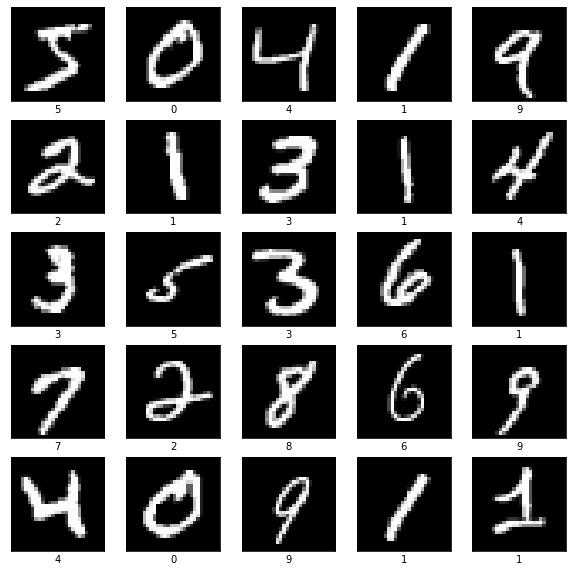

In [30]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.gray)
  plt.xlabel(train_labels[i])
plt.show()

In [31]:
# Define the model architecture
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax)
])

# Define how to train the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the digit classification model
model.fit(train_images, train_labels, epochs=15)

Train on 60000 samples
Epoch 1/15
60000/60000 [==============================] - 22s 372us/sample - loss: 0.2784 - accuracy: 0.9220
Epoch 2/15
60000/60000 [==============================] - 22s 369us/sample - loss: 0.1098 - accuracy: 0.9693
Epoch 3/15
60000/60000 [==============================] - 22s 363us/sample - loss: 0.0807 - accuracy: 0.9769
Epoch 4/15
60000/60000 [==============================] - 22s 362us/sample - loss: 0.0662 - accuracy: 0.9808
Epoch 5/15
60000/60000 [==============================] - 22s 360us/sample - loss: 0.0574 - accuracy: 0.9830
Epoch 6/15
60000/60000 [==============================] - 22s 364us/sample - loss: 0.0501 - accuracy: 0.9851
Epoch 7/15
60000/60000 [==============================] - 22s 366us/sample - loss: 0.0449 - accuracy: 0.9863
Epoch 8/15
60000/60000 [==============================] - 22s 360us/sample - loss: 0.0413 - accuracy: 0.9878
Epoch 9/15
60000/60000 [==============================] - 21s 357us/sample - loss: 0.0371 - accuracy: 0.9

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 12)        120       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 12)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2028)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                20290     
Total params: 20,410
Trainable params: 20,410
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Evaluate the model using all images in the test dataset.
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [34]:
# Convert Keras model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

Float model size = 81KBs.


In [35]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

Quantized model size = 22KBs,
which is about 27% of the float model size.


In [36]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_tflite_model(tflite_model):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

# Evaluate the TF Lite float model. You'll find that its accurary is identical
# to the original TF (Keras) model because they are essentially the same model
# stored in different format.
float_accuracy = evaluate_tflite_model(tflite_float_model)
print('Float model accuracy = %.4f' % float_accuracy)

# Evalualte the TF Lite quantized model.
# Don't be surprised if you see quantized model accuracy is higher than
# the original float model. It happens sometimes :)
quantized_accuracy = evaluate_tflite_model(tflite_quantized_model)
print('Quantized model accuracy = %.4f' % quantized_accuracy)
print('Accuracy drop = %.4f' % (float_accuracy - quantized_accuracy))

Float model accuracy = 0.9829
Quantized model accuracy = 0.9829
Accuracy drop = 0.0000


In [38]:
# Save the quantized model to file to the Downloads directory
f = open('mnist.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

# Download the digit classification model
from google.colab import files
files.download('mnist.tflite')

print('mnist.tflite has been downloaded')

mnist.tflite has been downloaded
